In [2]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/kaggle/input/dataset/EV_Data 2024.csv"
df = pd.read_csv(csv_path)

print(df.shape)
print(df.columns)
print(df.head())


(12654, 8)
Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')
      region    category       parameter  mode powertrain  year      unit  \
0  Australia  Historical  EV stock share  Cars         EV  2011   percent   
1  Australia  Historical  EV sales share  Cars         EV  2011   percent   
2  Australia  Historical        EV sales  Cars        BEV  2011  Vehicles   
3  Australia  Historical        EV stock  Cars        BEV  2011  Vehicles   
4  Australia  Historical        EV stock  Cars        BEV  2012  Vehicles   

       value  
0    0.00039  
1    0.00650  
2   49.00000  
3   49.00000  
4  220.00000  


### Step 1 – Creo un sotto-dataset minimo
- Tengo solo le righe in cui `parameter = EV stock share`.
- Filtro region su "Italy" e "Europe" con `.isin()`.
- Filtro anni dal 2015 in poi con `>= 2015`.
- Tengo solo le colonne region, year, value.
- Controllo se ci sono duplicati (più righe per la stessa region+year).


In [3]:
df_share = df[df["parameter"] == "EV stock share"].copy()

In [4]:
df_it_eu = df_share[
           (df_share["region"].isin(['Italy','Europe'])) &
          (df_share['year'] >= 2015)
][['region','year','value']].copy()

In [5]:
dup = (df_it_eu.groupby(['region','year'])
      .size() 
      .reset_index(name='n_rows')
      .sort_values(['region','year'])
)
print(dup.head(10))
print('Righe totali', len(df_it_eu))

   region  year  n_rows
0  Europe  2015       4
1  Europe  2016       4
2  Europe  2017       4
3  Europe  2018       4
4  Europe  2019       4
5  Europe  2020      12
6  Europe  2021      12
7  Europe  2022      12
8  Europe  2023      12
9  Europe  2025       8
Righe totali 118


### Step 2 — Condenso duplicati per (region, year)
Raggruppo per regione e anno e faccio la **media** della quota EV (`value`) per ottenere una sola riga per ogni coppia (paese, anno).
Scelte alternative: `median()` per robustezza; `sum()` per volumi (non per percentuali); media ponderata se ho pesi affidabili.


In [7]:
df_it_eu_clean = (df_it_eu.groupby(['region','year'],
                 as_index=False)['value']
                 .mean()
                 )
print(df_it_eu_clean.head(10))
print('Righe dopo condensazione:', len(df_it_eu_clean))

   region  year     value
0  Europe  2015  0.144800
1  Europe  2016  0.187425
2  Europe  2017  0.182350
3  Europe  2018  0.241000
4  Europe  2019  0.342750
5  Europe  2020  0.528250
6  Europe  2021  0.799750
7  Europe  2022  1.156750
8  Europe  2023  1.685000
9  Europe  2025  3.586250
Righe dopo condensazione: 21


### Step 3 — Converto il dataset in formato wide
Uso `.pivot()` per mettere gli anni come indice e avere due colonne (Italy, Europe).  
Così sarà molto più facile plottare due linee sullo stesso grafico.


In [9]:
wide = (df_it_eu_clean.pivot(
       index='year', columns='region', values='value')
       .sort_index()
)
print(wide.head(10))

region    Europe     Italy
year                      
2015    0.144800  0.034000
2016    0.187425  0.044000
2017    0.182350  0.052667
2018    0.241000  0.087333
2019    0.342750  0.256667
2020    0.528250  0.333333
2021    0.799750  0.503333
2022    1.156750  0.690000
2023    1.685000  0.983333
2025    3.586250       NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Risultato del pivot
Ora ho una tabella "wide" con anni come indice e due colonne (Europe, Italy).
I valori rappresentano la quota % di EV sul parco auto.
- Nel 2015 l'Italia era intorno a 0.03%, l'Europa a 0.14%.
- Nel 2023: Italia ~0.98%, Europa ~1.68%.
- Nel 2025 manca il dato per l’Italia (NaN), quindi lo useremo solo fino al 2023.


### Step 4 — Grafico lineare
Uso `plt.plot()` per disegnare due linee (Italia, Europa) dal 2015 al 2023.
- Asse X: anni
- Asse Y: quota EV (% sul parco auto)
- Marker "o" per mostrare i singoli anni
- Legenda e griglia per leggibilità


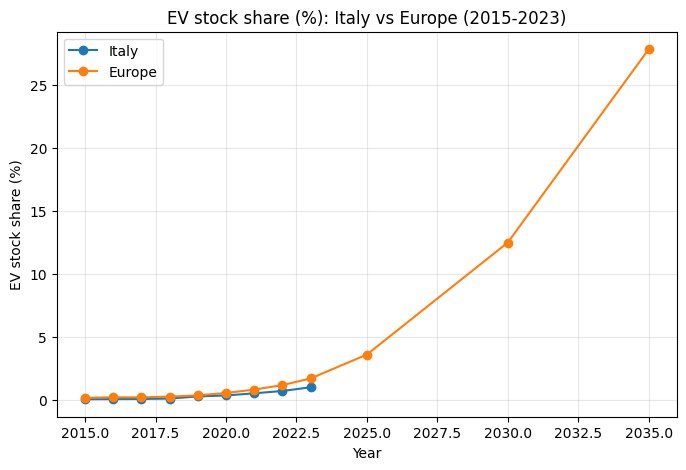

In [18]:
plt.figure(figsize=(8,5))

plt.plot(wide.index, wide['Italy'],marker='o', label='Italy')
plt.plot(wide.index, wide['Europe'],marker='o', label='Europe')

plt.title('EV stock share (%): Italy vs Europe (2015-2023)')
plt.xlabel ('Year')
plt.ylabel ('EV stock share (%)')

plt.legend()

plt.grid(True, alpha=0.3)

plt.savefig("/kaggle/working/ev-stock-share_italy-vs-europe_2015-2023.png", 
            dpi=300, bbox_inches="tight")


plt.show()

### Step 5 — Tabella di sintesi numerica
Per Italia ed Europa calcolo:
- Valore iniziale (2015)
- Valore finale (2023)
- Variazione assoluta
- Variazione relativa %
- CAGR % (crescita media annua)


In [16]:
wide_hist = wide.loc[2015:2023] 

it_2015 = float(wide_hist.at[2015, "Italy"])  
it_2023 = float(wide_hist.at[2023, "Italy"])
eu_2015 = float(wide_hist.at[2015, "Europe"])
eu_2023 = float(wide_hist.at[2023, "Europe"])

def synth(start_val, end_val, years=2023-2015):
    abs_change = end_val - start_val                   
    rel_change = (end_val / start_val - 1) * 100           
    cagr = ((end_val / start_val) ** (1/years) - 1) * 100  
    return {
        "2015": start_val,
        "2023": end_val,
        "Variazione assoluta": abs_change,
        "Variazione %": rel_change,
        "CAGR %": cagr
    }


summary = {
    "Italy":  synth(it_2015, it_2023),
    "Europe": synth(eu_2015, eu_2023)
}


import pandas as pd
summary_df = pd.DataFrame(summary).T.round(2)
print(summary_df)


        2015  2023  Variazione assoluta  Variazione %  CAGR %
Italy   0.03  0.98                 0.95       2792.16   52.28
Europe  0.14  1.68                 1.54       1063.67   35.90


### Interpretazione

Tra il 2015 e il 2023, la quota di auto elettriche in Italia è aumentata di circa 28 volte, con una crescita media annua del 52%. Tuttavia, la media europea è rimasta più alta in valore assoluto (1.68% contro 0.98% nel 2023). Questo suggerisce che l’Italia stia recuperando terreno a ritmo veloce, ma partendo da una base molto più bassa resta ancora indietro rispetto alla media UE.

### Estensione possibile

Aggiungere altri paesi, includere proiezioni al 2030/2035, confrontare vendite annuali (EV sales) oltre alla quota di stock share”.

In [ ]:

out_dir = "/kaggle/working"

wide_hist.to_csv(f"{out_dir}/wide-historical_2015-2023.csv")
summary_df.to_csv(f"{out_dir}/summary-ev-stock-share_2015-2023.csv")